<a href="https://colab.research.google.com/github/Indian-otaku/Invasive_Species_Classifier/blob/main/mp_ias_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d dsidharth/invasive-species-in-kerala-india

 99% 1.43G/1.44G [00:17<00:00, 129MB/s]
100% 1.44G/1.44G [00:17<00:00, 90.4MB/s]


In [4]:
!unzip '*.zip'
!mkdir Full_data

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1582.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1583.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1584.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1585.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1586.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1587.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1588.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_159.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1590.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1591.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1592.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1593.jpg  
  inflating: Dataset/Prosopis juliflora/Prosopis_juliflora1_1594.jpg  
  inflating: Dataset/Prosop

In [5]:
import os
import random
import shutil
import pathlib

random.seed(39)

full_data_path = r"/content/Dataset"
destination_dir = r"/content/Full_data"

plant_names = [
    name
    for name in os.listdir(full_data_path)
    if os.path.isdir(os.path.join(full_data_path, name))
]
for plant in plant_names:
    print(plant)
print("Length: ", len(plant_names))

def train_test_split(source_dir, source_folder, dest_dir, train_set_size=750):
    dest_folder = source_folder
    source = os.path.join(source_dir, source_folder)

    train_dir = os.path.join(dest_dir, "Train")
    test_dir = os.path.join(dest_dir, "Test")
    train_folder = os.path.join(train_dir, dest_folder)
    test_folder = os.path.join(test_dir, dest_folder)

    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    images = os.listdir(source)
    selected_images = random.sample(images, min(train_set_size, len(images)))

    for image in selected_images:
        src_path = os.path.join(source, image)
        dst_path = os.path.join(train_folder, image)
        shutil.copy2(src_path, dst_path)
    for image in images:
        if image not in selected_images:
            src_path = os.path.join(source, image)
            dst_path = os.path.join(test_folder, image)
            shutil.copy2(src_path, dst_path)


for plant in plant_names:
    train_test_split(
        source_dir=full_data_path, source_folder=plant, dest_dir=destination_dir
    )

Ipomoea cairica
Mikania micrantha
Acacia mearnsii
Chromolaena odorata
Prosopis juliflora
Antigonon leptopus
Sphagneticola trilobata
Senna spectabilis
Parthenium hysterophorus
Arundo donax
Salvinia molesta
Pistia stratiotes
Cabomba furcata
Pontederia crassipes
Mimosa diplotricha
Lantana camara
Length:  16


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import InceptionV3, inception_v3
from tensorflow.keras.metrics import Recall, Accuracy
from tensorflow.keras.utils import image_dataset_from_directory

import numpy as np
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 8
RANDOM_SEED = 39
EPOCHS = 45

In [5]:
plant_names = [
    "Acacia mearnsii",
    "Antigonon leptopus",
    "Arundo donax",
    "Cabomba furcata",
    "Chromolaena odorata",
    "Ipomoea cairica",
    "Lantana camara",
    "Mikania micrantha",
    "Mimosa diplotricha",
    "Parthenium hysterophorus",
    "Pistia stratiotes",
    "Prosopis juliflora",
    "Salvinia molesta",
    "Senna spectabilis",
    "Sphagneticola trilobata",
    "Pontederia crassipes"
]

In [6]:
def plot_history(history, valid=True):
    plt.figure(figsize=(15, 5))
    history = history.history
    metrics = list(history.keys())
    n_graphs = len(history)
    if valid:
        n_graphs = int(n_graphs / 2)
    for i in range(n_graphs):
        plt.subplot(1, n_graphs, i + 1)
        plt.plot(history[metrics[i]], label="train")
        if valid:
            plt.plot(history[metrics[n_graphs + i]], label="valid")
        plt.title(metrics[i])
        plt.legend()
    plt.show()


In [7]:
data_path = r"./Full_data/Train"

train_data = image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=plant_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=0.2,
    subset="training",
)

validation_data = image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=plant_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=0.2,
    subset="validation",
)

Found 11982 files belonging to 16 classes.
Using 9586 files for training.
Found 11982 files belonging to 16 classes.
Using 2396 files for validation.


In [8]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_data))
print('Number of full validation batches: %d' % tf.data.experimental.cardinality(validation_data))

Number of train batches: 1199
Number of full validation batches: 300


In [9]:
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches // 5)
valid_data = validation_data.skip(val_batches // 5)

In [10]:
print(f'Number of validation batches: {tf.data.experimental.cardinality(valid_data)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_data)}')

Number of validation batches: 240
Number of test batches: 60


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(AUTOTUNE)
valid_data = valid_data.prefetch(AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)

In [15]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", seed=RANDOM_SEED),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=RANDOM_SEED),
        layers.RandomContrast(0.1, seed=RANDOM_SEED),
        layers.RandomBrightness(0.1, value_range=(0, 1), seed=RANDOM_SEED),
        layers.RandomRotation(0.1, seed=RANDOM_SEED),
        layers.RandomZoom(0.1, 0.1, seed=RANDOM_SEED),
    ]
)

In [16]:
base_model = InceptionV3(include_top=False)
base_model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [17]:
import random

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

inputs = layers.Input(shape=(256, 256, 3))
x = layers.Lambda(data_augmentation) (inputs)
x = inception_v3.preprocess_input(inputs)
x = base_model(x)
x = layers.Flatten() (x)
x = layers.Dropout(0.8) (x)
outputs = layers.Dense(16, activation="softmax") (x)

model1 = Model(inputs=inputs, outputs=outputs)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dropout (Dropout)           (None, 73728)             0     

In [18]:
model1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[Recall(), Accuracy()],
)

history1 = model1.fit(
    train_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_data,
    shuffle=True,
    verbose=2
)

Epoch 1/45
1199/1199 - 75s - loss: 8.0855 - recall: 0.5213 - accuracy: 0.0852 - val_loss: 7.0783 - val_recall: 0.6555 - val_accuracy: 0.1981 - 75s/epoch - 62ms/step
Epoch 2/45
1199/1199 - 43s - loss: 6.5151 - recall: 0.6911 - accuracy: 0.3438 - val_loss: 6.1198 - val_recall: 0.7088 - val_accuracy: 0.3552 - 43s/epoch - 35ms/step
Epoch 3/45
1199/1199 - 43s - loss: 5.8599 - recall: 0.7473 - accuracy: 0.5312 - val_loss: 8.7843 - val_recall: 0.6957 - val_accuracy: 0.5196 - 43s/epoch - 36ms/step
Epoch 4/45
1199/1199 - 43s - loss: 5.3947 - recall: 0.7846 - accuracy: 0.6484 - val_loss: 9.1746 - val_recall: 0.7260 - val_accuracy: 0.6123 - 43s/epoch - 36ms/step
Epoch 5/45
1199/1199 - 43s - loss: 4.8183 - recall: 0.8103 - accuracy: 0.7209 - val_loss: 8.7760 - val_recall: 0.7390 - val_accuracy: 0.6775 - 43s/epoch - 36ms/step
Epoch 6/45
1199/1199 - 43s - loss: 4.4812 - recall: 0.8265 - accuracy: 0.7754 - val_loss: 11.1448 - val_recall: 0.7218 - val_accuracy: 0.7236 - 43s/epoch - 36ms/step
Epoch 7/4

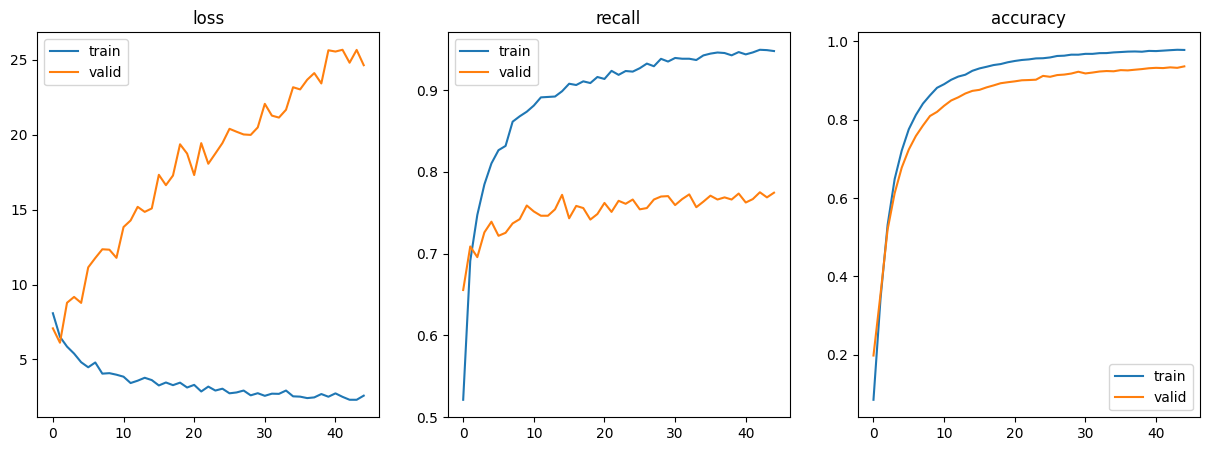

In [19]:
plot_history(history1)

In [21]:
model1.evaluate(valid_data)

240/240 [==============================] - 28s 100ms/step - loss: 24.8501 - recall: 0.7745 - accuracy: 0.9358


[24.850122451782227, 0.774530291557312, 0.9358037710189819]

In [22]:
model1.evaluate(test_data)

60/60 [==============================] - 3s 41ms/step - loss: 28.5956 - recall: 0.7521 - accuracy: 0.9337


[28.595613479614258, 0.7520833611488342, 0.9337239861488342]

In [23]:
test_data_path = r"./Full_data/Test"

test_data2 = image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=plant_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    seed=RANDOM_SEED
)

Found 11982 files belonging to 16 classes.


In [24]:
model1.evaluate(test_data2)

1498/1498 [==============================] - 62s 41ms/step - loss: 5.1277 - recall: 0.9537 - accuracy: 0.9848


[5.1276984214782715, 0.9536805152893066, 0.9847583770751953]

In [29]:
model1.save("./Saved_Model_weights1/model.h5")